<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List, Callable

import seaborn
seaborn.set(palette='summer')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [6]:
# Загрузим датасет
dataset = load_dataset('imdb', split='unsupervised')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [7]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for text in tqdm(dataset['text']):
    # токенизируем наши предложения, переводя их в нижний регистр
    list_sent = sent_tokenize(text.lower())
    
    # токенизируем наши предложения по словам и добавляем их в случае, если количество слов меньше порога
    sentences.extend(filter(lambda x: len(x)<word_threshold,(word_tokenize(sent) for sent in list_sent)))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 385965


Посчитаем для каждого слова его встречаемость.

In [9]:
words = Counter()

# Расчет встречаемости слов
words = Counter((e for r in sentences for e in r ))

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [10]:
vocab = set()
vocab_size = 40000

# Наполнение словаря
vocab = {k for k, _ in sorted(words.items(), key=lambda x: x[1], reverse=True)[:vocab_size]} | {'<unk>', '<bos>', '<eos>', '<pad>'}

In [11]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [12]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [13]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [14]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # Допишите код здесь
        return [self.bos_id] + [word2ind.get(x, self.unk_id) for x in self.data[idx]] + [self.eos_id]

    def __len__(self) -> int:
        return len(self.data)

In [15]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [16]:
# исправил тут ошибку, теперь ни какая из выборок не пересекается друг с другом
train_val_sentences, test_sentences = train_test_split(sentences, test_size=0.1, random_state=42)
train_sentences, eval_sentences = train_test_split(train_val_sentences, test_size=0.2, random_state=42)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [17]:
def evaluate(model:Callable, criterion, dataloader:DataLoader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [18]:
def train_model(model: Callable,
                train_loader: DataLoader,
                eval_loader: DataLoader,
                test_loader: DataLoader,
                optimizer: torch.optim.Optimizer = None,
                criterion: Callable = None,
                num_epochs: int = 5) -> tuple[list[float], list[float]]:
    if criterion is None:
        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters())

    perplexity_val = []
    perplexity_test = []
    eval_train = len(train_dataloader) // 2
    
    for epoch in range(num_epochs):
        epoch_losses = []
        model.train()

        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # оценка перплексии на валидационной выборке
            if i % eval_train == 0:
                model.eval()
                perplexity_val.append(evaluate(model, criterion, eval_loader))
                model.train()
        
        # оценка перплексии на тестовой выборке
        model.eval()
        perplexity_test.append(evaluate(model, criterion, test_loader))

    return perplexity_val, perplexity_test


### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

Модель будет почти идентична семинарной, за исключением rnn слоя, который будет использовать двуслойную двунаправленную LSTM вместо GRU

In [17]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int = 128, vocab_size: int = 40_004):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

Будем делать 3 прогона по 7 эпох без задания сида.

Training epoch 0::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/2172 [00:00<?, ?it/s]

[39156.556421213165, 21.62622789344296, 5.335672829910756, 2.9679566105865423, 2.253800319264168, 1.930819784738741, 1.7505284844182474, 1.6403505806545307, 1.569549750667031, 1.5087193746812655, 1.5141295963009858, 1.4284885836350105, 1.4217141748133286, 1.3886305879712324] [5.4147187652966835, 2.264916444061608, 1.7569905578695386, 1.5741528142366978, 1.5169694617094582, 1.4272591136149224, 1.369685297770216]


Training epoch 0::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/2172 [00:00<?, ?it/s]

[38831.00377676105, 16.20295029670055, 3.8850542691092027, 2.521022473909578, 2.0340120017418766, 1.7724267523152613, 1.661437579720499, 1.5407805976288094, 1.4796868799799714, 1.4268432996110583, 1.396765126707804, 1.3695667839401555, 1.3413397945312724, 1.33343515211706] [3.899120041076711, 2.0411546273736763, 1.6847582475239078, 1.4852987764686938, 1.40176643441055, 1.3429956459841192, 1.3136526267260116]


Training epoch 0::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/2172 [00:00<?, ?it/s]

[38941.888272617405, 23.08572366268376, 3.7401004689394, 2.1117685348289448, 1.7055501536111146, 1.5216432443200774, 1.4277707417366914, 1.3576238289283344, 1.3262539241414921, 1.283088788801794, 1.2600607173877527, 1.23570239390238, 1.2218811479062666, 1.2032294699280741] [3.7719875518849353, 1.7103038947313827, 1.4278568704396684, 1.327309601749016, 1.2613746058072475, 1.222063242599664, 1.193778400389564]


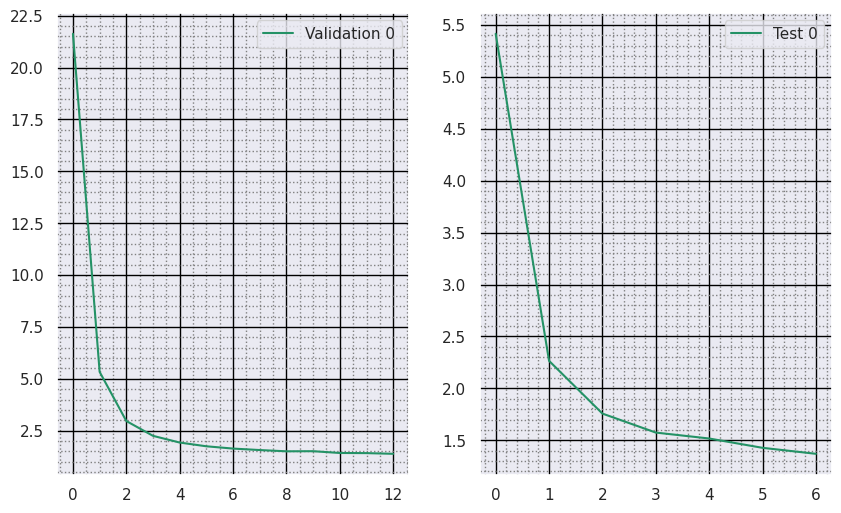

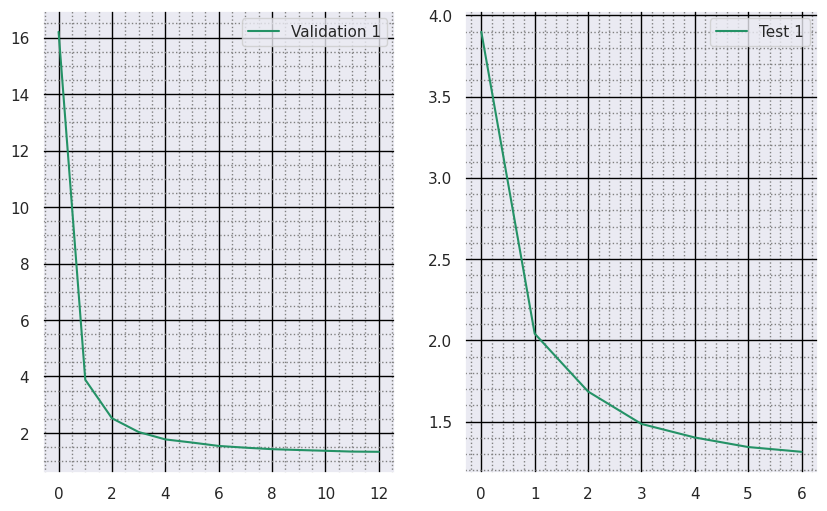

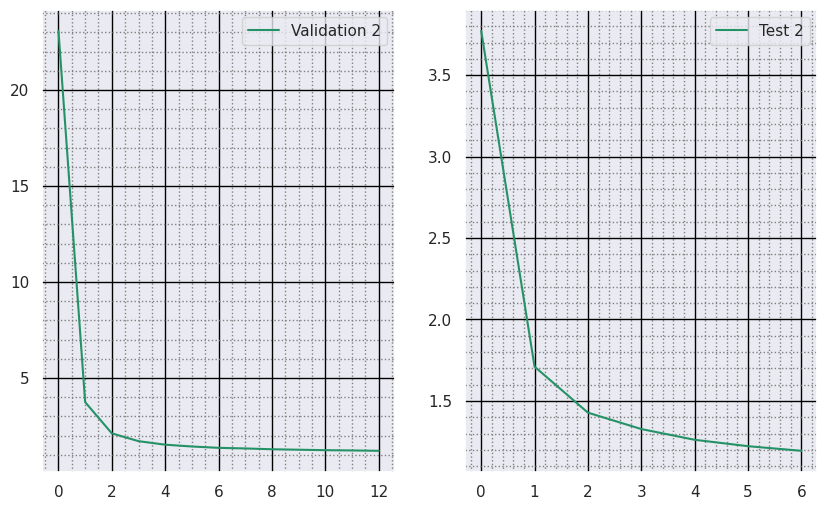

In [18]:
for i in range(3):
    model = LanguageModel().to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    # fused переносит часть вычислений на видеокартку, что делает обучение немного быстрее
    optimizer = torch.optim.Adam(model.parameters(), fused=True) 

    per_val, per_test = train_model(model=model,
                                    train_loader=train_dataloader,
                                    eval_loader=eval_dataloader,
                                    test_loader=test_dataloader,
                                    optimizer=optimizer,
                                    criterion=criterion,
                                    num_epochs=7)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    print(per_val, per_test)

    ax1.plot(per_val[1:], label=f'Validation {i}')

    ax1.grid(which='major',
            color = 'k')

    ax1.minorticks_on()
    ax1.grid(which='minor',
            color = 'gray',
            linestyle = ':')

    ax2.plot(per_test, label=f'Test {i}')

    ax2.grid(which='major',
            color = 'k')

    ax2.minorticks_on()
    ax2.grid(which='minor',
            color = 'gray',
            linestyle = ':')

    ax1.legend()
    ax2.legend()

По итогу 3 прогон оказался самым удачным в плане обучения, так как именно на нём мы смогли достичь самой маленькой перплексии

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

Добавим LayerNorm, так как он часто используется в задачах NLP. На вопрос "куда ставить" ответ простой: Нормализация -> Активация -> Дропаут

In [19]:
class LanguageModel2(nn.Module):
    def __init__(self, hidden_dim: int = 128, vocab_size: int = 40_004):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        
        self.norm = nn.LayerNorm(hidden_dim*2)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(self.norm(output))))
        projection = self.projection(self.non_lin(output))

        return projection

Training epoch 0::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/2172 [00:00<?, ?it/s]

[33792.83908120396, 1.5589525837924598, 1.1949989306114435, 1.1017979519582366, 1.0630123635023339, 1.0416266894033162, 1.030203822787515, 1.0223423602611759, 1.0183996060935174, 1.0155242029474585, 1.0132803875218879, 1.0115370563819703, 1.009970538304436, 1.0090530392873354] [1.1954521801298028, 1.0640500183926513, 1.0307706266838983, 1.0188362322106266, 1.0135449100014389, 1.0102375587880217, 1.009675453830239]


Training epoch 0::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/2172 [00:00<?, ?it/s]

[34688.2684953384, 1.5624595072607528, 1.2009800345419082, 1.1040952225416405, 1.0653285194277544, 1.0428803825466233, 1.0322508864639872, 1.0230149131673036, 1.018894422778767, 1.0156483801688938, 1.0144313683606423, 1.0118490903197512, 1.0102367106941743, 1.0091375261819604] [1.2008824707656507, 1.0661799580056146, 1.0319298493941098, 1.0191556724491497, 1.0141037331511642, 1.0104063887469816, 1.0088784745986887]


Training epoch 0::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/2172 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/2172 [00:00<?, ?it/s]

[34302.15517092541, 1.5781794255170594, 1.2083265059121626, 1.108704741268966, 1.0679182167650367, 1.0445605375929212, 1.032404791584331, 1.023895175637022, 1.0199570229918478, 1.016142842519349, 1.0142100206396198, 1.0119754438242201, 1.0103778604205362, 1.0094991503060413] [1.2081124056254002, 1.0681217281234185, 1.0329104693520148, 1.0200499375134904, 1.014394818947015, 1.0106283919700723, 1.0091015151794382]


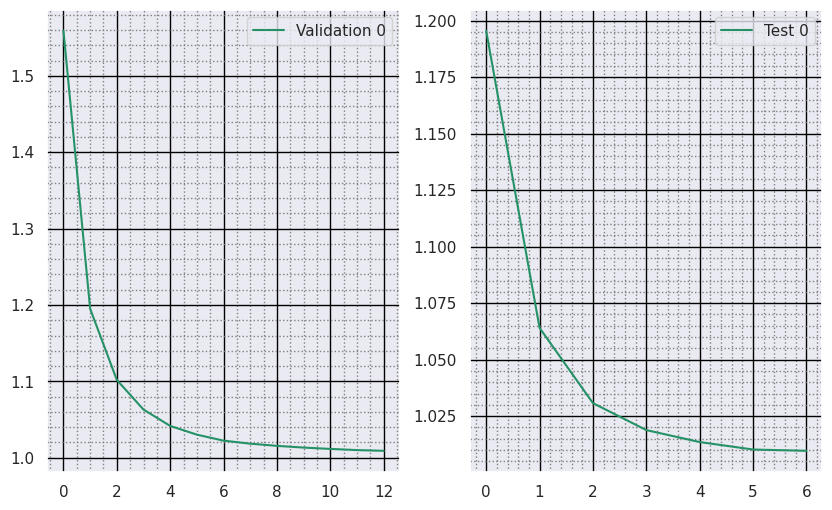

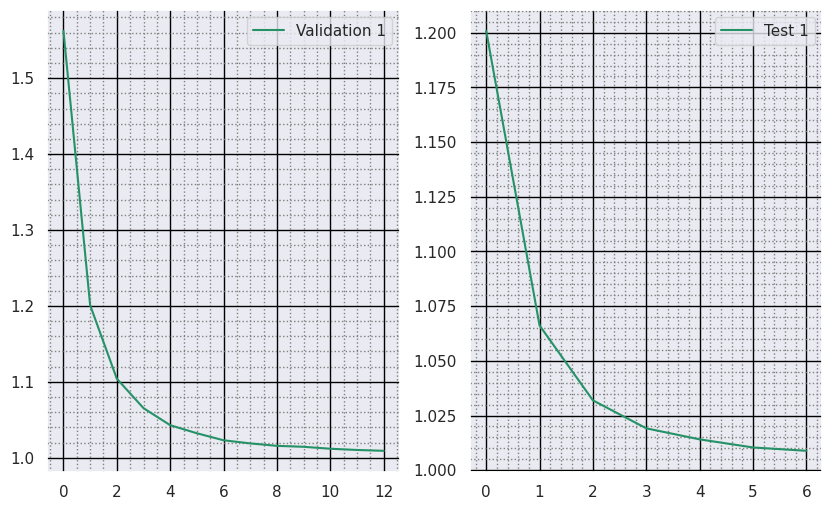

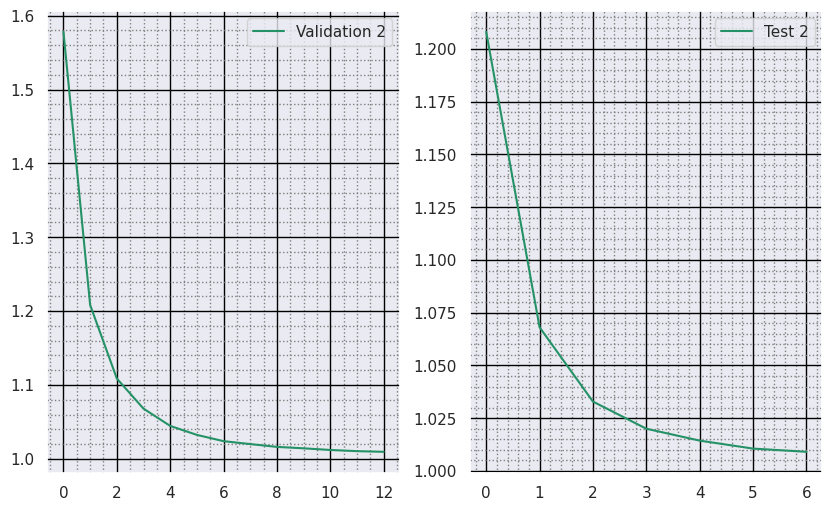

In [20]:
for i in range(3):
    model = LanguageModel2().to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(), fused=True)

    per_val, per_test = train_model(model=model,
                                    train_loader=train_dataloader,
                                    eval_loader=eval_dataloader,
                                    test_loader=test_dataloader,
                                    optimizer=optimizer,
                                    criterion=criterion,
                                    num_epochs=7)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    print(per_val, per_test)

    ax1.plot(per_val[1:], label=f'Validation {i}')

    ax1.grid(which='major',
            color = 'k')

    ax1.minorticks_on()
    ax1.grid(which='minor',
            color = 'gray',
            linestyle = ':')

    ax2.plot(per_test, label=f'Test {i}')

    ax2.grid(which='major',
            color = 'k')

    ax2.minorticks_on()
    ax2.grid(which='minor',
            color = 'gray',
            linestyle = ':')

    ax1.legend()
    ax2.legend()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Сначала про нашу baseline модель. Наша LSTM модель, отличающаяся от семинарской модели только заменой LSTM на GRU, смогла достичь достаточно никзой перплексии в размере всего 1.19 на тестовой выборке, что является хорошим значением.

Теперь про вторую версию модели. Здесь мы добавили нормализацию, которая улучшила результаты нашей модели, сделав перплексию ещё ближе к 1. Теоретически мы максимально приблизись к минимальной перплексии на настолько не разнообразном датасете, но это лишь теория.

Теперь про идеи для улучшения:
- Использовать RMSNorm вместо LayerNorm, так как он может немного улучшить результаты нашей модели вместе с уменьшением необходимой вычислительной мощности.
- Попробовать использовать нормализацию между LSTM слоями.
- Попробовать больше эпох, так как модель все ещё немного улучшается.
- Использовать scheduler для уменьшения шага оптимизатора.
- Добавить ещё один линейный скрытый слой.
- Попробовать ReLU в качестве функции активации для линейного слоя.